In [7]:
#Import modules
#import yahoo_fin.stock_info as si
import numpy as np
#from investingCredentials import username, pw
#from selenium import webdriver
from time import sleep
#from selenium.webdriver.common.by import By
import pandas as pd

In [22]:
#url to scrape
url = "https://www.investing.com/crypto/bitcoin/historical-data"
from selenium import webdriver
#create class for bot
class timeSeriesGrabber:
    def __init__(self, url, username, pw):
        #open the historical data page
        self.driver = webdriver.Chrome('/home/agustin/Git-Repos/algo-trading-crypto/sm-interactor/'
                                       'sm_interactor/app/chromedriver')
        self.driver.get(url)
        sleep(4)
        
        #click download data to bring up sign in
        self.driver.find_element(By.XPATH,
             "//a[contains(text(), 'Download Data')]").click()
        sleep(2)
        
        #send credentials into input boxes
        self.driver.find_element(By.ID, "loginFormUser_email").send_keys(username)
        sleep(1)
        self.driver.find_element(By.ID, "loginForm_password").send_keys(pw)
        sleep(1)
        
        #click sign in button
        self.driver.find_element(By.XPATH, "/html/body/div[9]/div[2]/a").click()
        sleep(1)
        
        #scroll down
        self.driver.execute_script("window.scrollTo(0, 280)")
        sleep(2)
        #click into date panel
        self.driver.find_element(By.ID, "widgetField").click()
        
        #clear dates and send new ones
        self.driver.find_element(By.ID, "startDate").clear()
        sleep(.5)
        self.driver.find_element(By.ID, "startDate").send_keys('01/01/2008')
        sleep(.5)
        self.driver.find_element(By.ID, "endDate").clear()
        sleep(.5)
        self.driver.find_element(By.ID, "endDate").send_keys('01/01/2030')
        
        #click apply
        self.driver.find_element(By.ID, "applyBtn").click()
        sleep(7)
        
        #download data
        self.driver.find_element(By.XPATH,
            "/html/body/div[5]/section/div[7]/div[2]/div[4]/div/a").click()
        sleep(7)

In [23]:
# run it        

timeSeriesGrabber(url, username, pw)

<ipython-input-22-4b538a9d7850>:8: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  self.driver = webdriver.Chrome('/home/agustin/Git-Repos/algo-trading-crypto/sm-interactor/'


SessionNotCreatedException: Message: session not created: This version of ChromeDriver only supports Chrome version 103
Current browser version is 109.0.5414.119 with binary path /usr/bin/google-chrome
Stacktrace:
#0 0x55e445293b13 <unknown>
#1 0x55e44509a688 <unknown>
#2 0x55e4450c2ad0 <unknown>
#3 0x55e4450be248 <unknown>
#4 0x55e4450ba5aa <unknown>
#5 0x55e4450f564a <unknown>
#6 0x55e4450ef7a3 <unknown>
#7 0x55e4450c50ea <unknown>
#8 0x55e4450c6225 <unknown>
#9 0x55e4452db2dd <unknown>
#10 0x55e4452df2c7 <unknown>
#11 0x55e4452c522e <unknown>
#12 0x55e4452e00a8 <unknown>
#13 0x55e4452b9bc0 <unknown>
#14 0x55e4452fc6c8 <unknown>
#15 0x55e4452fc848 <unknown>
#16 0x55e445316c0d <unknown>
#17 0x7efe7d28d609 <unknown>


In [8]:
import math
import pandas as pd
import os.path
from datetime import timedelta, datetime
from dateutil import parser
from binance.client import Client as Client_binance


class BinanceClient(object):

    def __init__(self,
                 config):
        self.binance_api_key = config['binance_api_key']
        self.binance_api_secret = config['binance_api_secret']

        self.client = Client_binance(api_key=self.binance_api_key, api_secret=self.binance_api_secret)

    ### FUNCTIONS
    def minutes_of_new_data(self, symbol, initial_date,
                            kline_size, data, source):
        if len(data) > 0:
            old = parser.parse(data["timestamp"].iloc[-1])
        elif source == "binance":
            old = datetime.strptime(initial_date, '%d %b %Y')
        if source == "binance":
            new = pd.to_datetime(self.client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
        return old, new
    
    def get_all_binance(self, symbol, initial_date, freq, save=False):
        binsizes = {"1m": 1, "5m": 5, "10m": 10, "15m": 15, "1h": 60, "6h": 360, "12h": 720, "1d": 1440}
        filename = '/home/agustin/Git-Repos/algo-trading-crypto/il-hedger/il_hedger/files/%s-%s-data.csv' % (symbol, freq)
        if os.path.isfile(filename):
            data_df = pd.read_csv(filename)
        else:
            data_df = pd.DataFrame()
        oldest_point, newest_point = self.minutes_of_new_data(symbol, initial_date,
                                                              freq, data_df, source="binance")
        delta_min = (newest_point - oldest_point).total_seconds() / 60
        available_data = math.ceil(delta_min / binsizes[freq])
        if oldest_point == datetime.strptime(initial_date, '%d %b %Y'):
            print('Downloading all available %s data for %s. Be patient..!' % (freq, symbol))
        else:
            print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.'
                  % (delta_min, symbol, available_data, freq))
        klines = self.client.get_historical_klines(symbol, freq,
                                                   oldest_point.strftime("%d %b %Y %H:%M:%S"),
                                                   newest_point.strftime("%d %b %Y %H:%M:%S"))
        data = pd.DataFrame(klines,
                            columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av',
                                     'trades', 'tb_base_av', 'tb_quote_av', 'ignore'])
        data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
        if len(data_df) > 0:
            temp_df = pd.DataFrame(data)
            data_df = data_df.append(temp_df)
        else:
            data_df = data
        data_df.set_index('timestamp', inplace=True)
        if save:
            data_df.to_csv(filename)
        print('All caught up..!')
        return data_df

import json

with open('/home/agustin/Git-Repos/HedgingScripts/files/StgyApp_config.json') as json_file:
    config = json.load(json_file)
_binance_client_ = BinanceClient(config['binance_client'])


# Track historical data
symbol_eth = 'ETHBUSD'
symbol_btc = 'BTCBUSD'
freq = '1d'
initial_date = "1 Jan 2021"
_binance_client_ = BinanceClient(config['binance_client'])
eth_historical = _binance_client_.get_all_binance(symbol=symbol_eth, freq=freq,
                              initial_date=initial_date, save=False)
btc_historical = _binance_client_.get_all_binance(symbol=symbol_btc, freq=freq,
                              initial_date=initial_date, save=False)
eth_prices = eth_historical['close']
for i in range(len(eth_prices)):
    eth_prices[i] = float(eth_prices[i])
btc_prices = btc_historical['close']
for i in range(len(btc_prices)):
    btc_prices[i] = float(btc_prices[i])

All caught up..!
All caught up..!


<ipython-input-8-6a9e21f37cc2>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices[i] = float(eth_prices[i])
<ipython-input-8-6a9e21f37cc2>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_prices[i] = float(btc_prices[i])


In [9]:
# data
# data = btc_historical
data_eth_2021 = pd.DataFrame(eth_prices).loc["2021-01-01":"2022-01-01"]
data_btc_2021 = pd.DataFrame(btc_prices).loc["2021-01-01":"2022-01-01"]

data_eth_2022 = pd.DataFrame(eth_prices).loc["2022-01-01":"2023-01-01"]
data_btc_2022 = pd.DataFrame(btc_prices).loc["2022-01-01":"2023-01-01"]

# Note that last dataset in each set of periods has a length of less than one expect for that period, 
# so is better to take all the periods except the last one. ie [:-1]

data_7days_eth_2021 = [data_eth_2021[i:i+7] for i in range(len(data_eth_2021)) if i % 7 == 0][:-1]
data_7days_btc_2021 = [data_btc_2021[i:i+7] for i in range(len(data_btc_2021)) if i % 7 == 0][:-1]

data_7days_eth_2022 = [data_eth_2022[i:i+7] for i in range(len(data_eth_2022)) if i % 7 == 0][:-1]
data_7days_btc_2022 = [data_btc_2022[i:i+7] for i in range(len(data_btc_2022)) if i % 7 == 0][:-1]

data_15days_eth_2021 = [data_eth_2021[i:i+15] for i in range(len(data_eth_2021)) if i % 15 == 0][:-1]
data_15days_btc_2021 = [data_btc_2021[i:i+15] for i in range(len(data_btc_2021)) if i % 15 == 0][:-1]

data_15days_eth_2022 = [data_eth_2022[i:i+15] for i in range(len(data_eth_2022)) if i % 15 == 0][:-1]
data_15days_btc_2022 = [data_btc_2022[i:i+15] for i in range(len(data_btc_2022)) if i % 15 == 0][:-1]

data_30days_eth_2021 = [data_eth_2021[i:i+30] for i in range(len(data_eth_2021)) if i % 30 == 0][:-1]
data_30days_btc_2021 = [data_btc_2021[i:i+30] for i in range(len(data_btc_2021)) if i % 30 == 0][:-1]

data_30days_eth_2022 = [data_eth_2022[i:i+30] for i in range(len(data_eth_2022)) if i % 30 == 0][:-1]
data_30days_btc_2022 = [data_btc_2022[i:i+30] for i in range(len(data_btc_2022)) if i % 30 == 0][:-1]

In [24]:
data_eth_2021

,close
timestamp,
2021-01-01,730.92
2021-01-02,775.28
2021-01-03,980.14
2021-01-04,1042.23
2021-01-05,1103.01
...,...
2021-12-28,3793.79
2021-12-29,3630.81
2021-12-30,3709.85


In [25]:
# from btcFilePath import btcFilePath
btcFilePath = "~/Git-Repos/volatilityAnalysis/BTC_TimeSeries.csv"

In [26]:
#run it        
# timeSeriesGrabber(url, username, pw)

#read csv to dataframe
timeSeries = pd.read_csv(btcFilePath)

#drop Change % column
timeSeries = timeSeries.drop("Change %", axis = 1)

#reformat date
timeSeries['Date'] = pd.to_datetime(timeSeries['Date'])

#set index to date column
timeSeries = timeSeries.set_index('Date')

#rename Price to Close and Vol. to Volume
timeSeries = timeSeries.rename(
              columns = {"Price":"Close", "Vol.":"Volume"}, errors = "raise")

#remove commas from prices and dashes from volume
timeSeries.replace(",","", regex = True, inplace = True)
timeSeries.replace("-","0", regex = True, inplace = True)

#remove K and M from volume data and move decimal point
for i in timeSeries['Volume'].index:
    if "K" in timeSeries.loc[i, 'Volume']:
        timeSeries.loc[i, 'Volume'] = float(timeSeries.loc[i, 'Volume'
                                            ].replace('K','')) * 1000
    elif "M" in timeSeries.loc[i, 'Volume']:
        timeSeries.loc[i, 'Volume'] = float(timeSeries.loc[i, 'Volume'
                                            ].replace('M','')) * 1000000
    elif "B" in timeSeries.loc[i, 'Volume']:
        timeSeries.loc[i, 'Volume'] = float(timeSeries.loc[i, 'Volume'
                                            ].replace('B','')) * 1000000000    
        
#convert to numeric data type
timeSeries[['Close', 'Open', 'High', 'Low', 'Volume']] = timeSeries[[
            'Close', 'Open', 'High', 'Low', 'Volume']].apply(pd.to_numeric)

ts = timeSeries
#reordering df
ts = timeSeries.reindex(index=ts.index[::-1])

In [27]:
timeSeries

,Close,Open,High,Low,Volume
Date,,,,,
2022-05-14,29702.0,29285.2,29899.9,28666.7,68790.0
2022-05-13,29284.4,28994.3,31002.7,28755.0,141230.0
2022-05-12,28976.0,29073.4,30136.7,26500.5,309480.0
2022-05-11,29068.2,31008.0,32113.6,27835.5,296900.0
2022-05-10,31007.5,30098.2,32621.2,29831.0,235610.0
...,...,...,...,...,...
2010-07-22,0.1,0.1,0.1,0.1,2160.0
2010-07-21,0.1,0.1,0.1,0.1,580.0
2010-07-20,0.1,0.1,0.1,0.1,260.0


### Descriptions

* Logreturns: Measure of change of price on the given time horizon (days, months, etc)


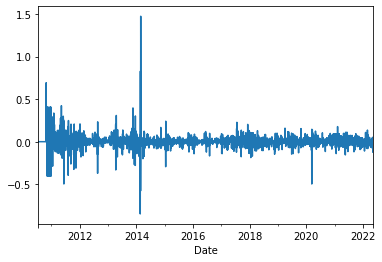

In [57]:
#daily log returns
ts['logRet'] = np.log(ts['Close']/ts['Close'].shift(1)) 
ts['logRet'] = ts['logRet'].fillna(0)
ts['logRet'].plot()#, 

* normalizedCandleHeight: By taking the height of the candle (High - low) and dividing it by price we get a vol metric that takes into account the whole range of movement and not just consecutive prices


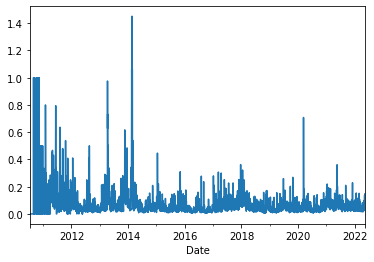

In [58]:
#price adjusted daily candle height - as a percent of price
ts['normalizedCandleHeight'] = (ts['High'] - ts['Low']) / ts['Close']
ts['normalizedCandleHeight'].plot()

* OffATH: Measures of points and percentages off highest prices. It is a measure of drawdowns with respect to all times high


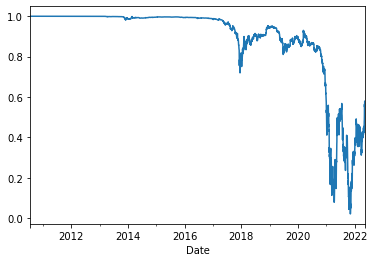

In [92]:
#min/max range in points
ts['allTimeLow'] = ts['Low'].min()
ts['allTimeHigh'] = ts['High'].max()

#percentage off ATH; AKA ATH drawdown
ts['pointsOffATH'] = ts['allTimeHigh'] - ts['Close']
ts['percentOffATH'] = ts['pointsOffATH'] / ts['allTimeHigh']

#plot

ts['percentOffATH'].plot()
# ts['pointsOffATH'].plot()

* rangeOverPrice: Similar to normalizedCandleHeight but with a lookback period. That lookback period gives this metric a trend consideration
	#can be > 1 if downtrending
	#can be < 1 if at all time high or uptrending


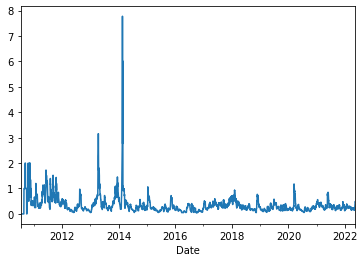

In [74]:
#rolling high/low range
rollingHighLowWindow = 20
ts['rollingLow'] = ts['Low'].rolling(rollingHighLowWindow).min()
ts['rollingHigh'] = ts['High'].rolling(rollingHighLowWindow).max()

#rolling high/low range over current price AKA price adjusted range
#can be > 1 if downtrending
#can be < 1 if at all time high or uptrending
#thus, trend is important consideration
# 
ts['rangeOverPrice'] = (
    ts['rollingHigh'] - ts['rollingLow']) / ts['Close']

#plot 
ts['rangeOverPrice'].plot()
# fig = plt.figure(figsize = (11,7))
# axs = fig.subplots(1)
# axs.plot(ts['rollingLow'])
# axs.plot(ts['rollingHigh'])
# axs.plot(ts['Close'])

* Z Score: It measures the distance between that raw score x and the population mean in units of the standard deviation. So extreme values means current obs is far away from mean behaviour


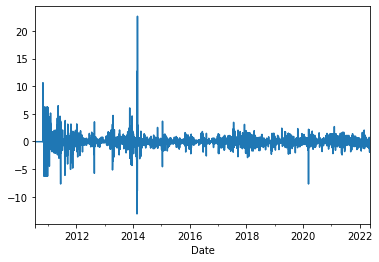

In [75]:
#log return Z Score
# The absolute value of z represents the distance between that raw score x and the population mean 
# in units of the standard deviation
# So extreme values means current obs is far away from mean behaviour
ts['avgLogReturn'] = ts['logRet'].mean()
ts['logReturnStdDev'] = ts['logRet'].std()
ts['logRetZScore'] = (
    ts['logRet'] - ts['avgLogReturn']) / ts['logReturnStdDev']

#plot
ts['logRetZScore'].plot()

* candle height Z Score: Similar to z score but taking normalizedCandleHeight values instead of logreturn. It measures how far for average behaviour the range of movement is. So instead of analizing movement itself it analyses ranges generated by those movmeent.


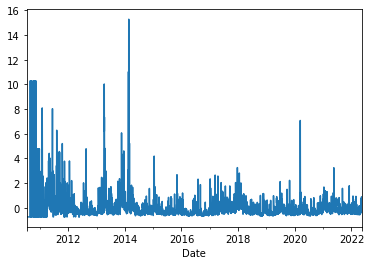

In [76]:
#candle height Z Score
#note, ts['normalizedCandleHeight'] and ts['candleHeightZScore'] have
#high correlation, but z score allows for comparability between time series
ts['avgCandleHeight'] = ts['normalizedCandleHeight'].mean()
ts['candleHeightStdDev'] = ts['normalizedCandleHeight'].std()
ts['candleHeightZScore'] = (
    ts['normalizedCandleHeight'] - ts['avgCandleHeight']
    ) / ts['candleHeightStdDev']

#plot
ts['candleHeightZScore'].plot()

* rollingAvgLogReturn and rollingStdDevLogReturn: Average logreturn and std of that but with a lookback period. So average beahvour and dispersion but with a look back period.


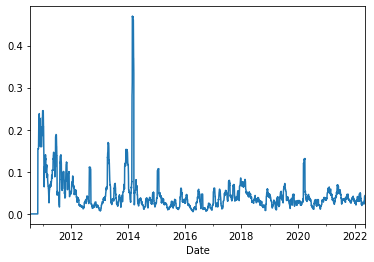

In [78]:
#rolling avg/stdDev window
rollingAvgStdDevWindow = 20

#rolling average log returns
# average log return but with a lookback period
ts['rollingAvgLogReturn'] = ts['logRet'].rolling(
    center=False, window = rollingAvgStdDevWindow).mean()

#plot
# ts['rollingAvgLogReturn'].plot()

###################################

#rolling stdDev log returns 
# Dispersion of last average behaviour metric
ts['rollingStdDevLogReturn'] = ts['logRet'].rolling(
    center=False, window = rollingAvgStdDevWindow).std()

#plot
ts['rollingStdDevLogReturn'].plot()

Also, by analyzing q = ts['rollingAvgLogReturn'].quantile(q=0.01, interpolation='nearest') we can estimate the 1% which moved less than q

In [80]:
#quantiles for rolling average log returns
# Bottom 1% value of our rollingavglog return
# the threshold for that 1% value
# This means that 1% moved less than -2.7% (in the last 20 days)
ts['rollingAvgLogReturn'].quantile(q=0.01, interpolation='nearest')

-0.027379466280087278

* rateOfChange: by substracting close today and close a lookback period in the past (and dividing by the last one) we can analyze vol and trend component. Also, very high and very low values identify trends as we will be substracting increasing values (on a uptrend) or decreasing values (on a downtrend) (threfore we will notice that movement in the values of the indicator (and in the plot))


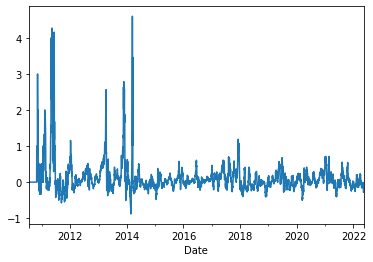

In [81]:
#rate of change window
rocWindow = 20
#rolling rate of change 
# It is a measure of volatility but it also has a trend component because of the lookback period 
# [we will be substracting increasing values (on a uptrend) or decreasing values (on a downtrend),
# threfore we will notice that movement in the values of the indicator (and in the plot)]
ts['rateOfChange'] = (ts['Close'] - ts['Close'].shift(rocWindow)
                                  ) / ts['Close'].shift(rocWindow)  
ts['rateOfChange'] = ts['rateOfChange'].fillna(0)

ts['rateOfChange'].plot()

* ATR (avgTrueRangePoints, avgTrueRangePercent): It measures the max ranges of movement (high - low) for the same day, and also (high - close), (low-close) for close of last day (this compares three ranges of movement taking recent info (today's and yesterday's close)). Then it calculates a rolling mean of that to incorporate a lookback period. 
	avgTrueRangePercent looks different bc high movements will make it look higher. 
	The good thing about this is that you can compare across time (you divide by CURRENT price)


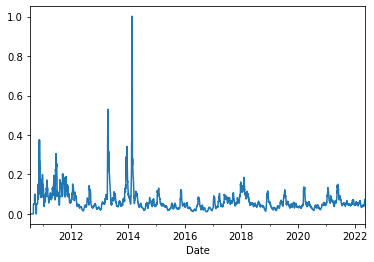

In [83]:
#ATR Setup
# It measures the max ranges of movement (high - low) for the same day 
# and high - close, low-close for close of last day
# then it calculates a rolling mean of that to incorporate a lookback period
avgTrueRangeWindow = 20
ts['Method1'] = ts['High'] - ts['Low']
ts['Method2'] = abs((ts['High'] - ts['Close'].shift(1)))
ts['Method3'] = abs((ts['Low'] - ts['Close'].shift(1)))
ts['Method1'] = ts['Method1'].fillna(0)
ts['Method2'] = ts['Method2'].fillna(0)
ts['Method3'] = ts['Method3'].fillna(0)
ts['TrueRange'] = ts[['Method1','Method2','Method3']].max(axis = 1)

ts['avgTrueRangePoints'] = ts['TrueRange'].rolling(
                      window = avgTrueRangeWindow, center=False).mean()    

# ts['avgTrueRangePoints'].plot() # as price movement

ts['avgTrueRangePercent'] = ts['avgTrueRangePoints'] / ts['Close']
 
ts['avgTrueRangePercent'].plot() # as pcg points movement

# It looks different in pcgs bc high moments will make it look higher
# The good thing about this is that you can compare across time (you divide by CURRENT price)

* efficiency = rate of change / ATR in points where = ts['ROCefficiency'] / ts['avgTrueRangePoints': It is a vol metric which also identify straigh line trends. High or low values means crypto was trending in a straight line (ROC will be high or low but AVR will be almost constant)

	'ROCefficiency' = ts['Close'] - ts['Close'].shift(rocWindow)
		IF that dif is >0 means price has gone up (now greater than before), otherwise it means price has gone down is kind of a trend metric

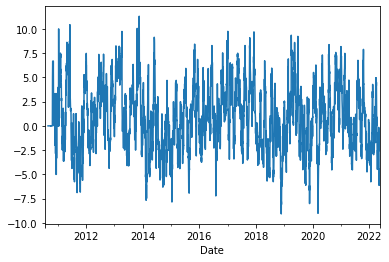

In [84]:
#efficiency = rate of change / ATR in points 
#high absolute values suggest larger moves, in a ~straight~ line
#ATR is in points to adjust for price 
ts['ROCefficiency'] = ts['Close'] - ts['Close'].shift(rocWindow)
# IF that dif is >0 means price has gone up (now greater than before), otherwise it means price has gone down
# is kind of a trend metric
ts['efficiency'] = ts['ROCefficiency'] / ts['avgTrueRangePoints'] 
# High or low values means crypto was trending in a straight line (ROC will be high or low but AVR will be almost constant)


ts['efficiency'].plot()

### Correlation Matrix


Finally, we can plot the correlation matrix to identify which indicators gives us information about distinct features of the volatility process within the price. Therefore we can utilize only those which are not correlated (or poorly correlated).

In [85]:
#subset for correlation matrix
corrMat = ts[['efficiency','avgTrueRangePercent','avgTrueRangePoints',
              'TrueRange','rateOfChange','rollingStdDevLogReturn',
              'rollingAvgLogReturn','candleHeightZScore','logRetZScore',
              'rangeOverPrice','percentOffATH',]][20:].corr()

In [87]:
corrMat

,efficiency,avgTrueRangePercent,avgTrueRangePoints,TrueRange,rateOfChange,rollingStdDevLogReturn,rollingAvgLogReturn,candleHeightZScore,logRetZScore,rangeOverPrice,percentOffATH
efficiency,1.000000,-0.191672,-0.076693,-0.033885,0.660978,-0.029556,0.807656,-0.027450,0.229114,-0.112852,0.025848
avgTrueRangePercent,-0.191672,1.000000,0.035408,0.019780,0.057933,0.728209,-0.126675,0.557916,-0.122342,0.898692,0.067654
avgTrueRangePoints,-0.076693,0.035408,1.000000,0.864696,-0.080335,-0.028319,-0.075202,0.006453,-0.021719,-0.028289,-0.930525
TrueRange,-0.033885,0.019780,0.864696,1.000000,-0.045064,-0.029725,-0.037166,0.100744,-0.037018,-0.013344,-0.819510
rateOfChange,0.660978,0.057933,-0.080335,-0.045064,1.000000,0.288357,0.928881,0.180283,0.207789,0.130938,0.063999
rollingStdDevLogReturn,-0.029556,0.728209,-0.028319,-0.029725,0.288357,1.000000,0.161162,0.375299,0.061587,0.580029,0.095629
rollingAvgLogReturn,0.807656,-0.126675,-0.075202,-0.037166,0.928881,0.161162,1.000000,0.035127,0.236953,-0.075753,0.038414
candleHeightZScore,-0.027450,0.557916,0.006453,0.100744,0.180283,0.375299,0.035127,1.000000,-0.133124,0.622437,0.048418
logRetZScore,0.229114,-0.122342,-0.021719,-0.037018,0.207789,0.061587,0.236953,-0.133124,1.000000,-0.110528,0.010188
rangeOverPrice,-0.112852,0.898692,-0.028289,-0.013344,0.130938,0.580029,-0.075753,0.622437,-0.110528,1.000000,0.105005


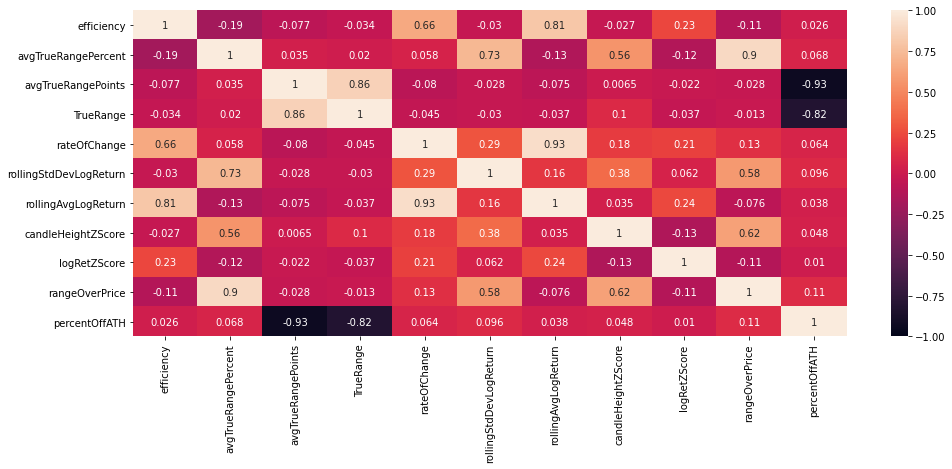

In [91]:
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.heatmap(corrMat,vmin=-1, vmax=1, annot=True)